In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
train  = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [3]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


In [4]:
train.head(3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S


### 特征工程

PassengerId:乘客编号

Survived:是否存活，0 否，1 是

Pclass:舱等，1、2、3

Name: 乘客名字

Sex:乘客性别

Age:乘客年龄

SibSp:兄弟姐妹及夫妻人数

Parch：父母及子女人数

Ticker:船票信息

Fare:票价

Cabin:客舱

Embarked:登陆港口

### 拟合优度检验

In [5]:
train[['Pclass','Survived']].groupby('Pclass',as_index = False).mean()

,Pclass,Survived
0,1,0.629630
1,2,0.472826
2,3,0.242363


In [6]:
train[["Sex", "Survived"]].groupby(['Sex'], as_index=False).mean()

,Sex,Survived
0,female,0.742038
1,male,0.188908


In [7]:
train[['Embarked','Survived']].groupby(['Embarked'],as_index = False).mean()

,Embarked,Survived
0,C,0.553571
1,Q,0.389610
2,S,0.336957


Pclass、Sex、Embarked 三个维度取值对 Survived 结果有明显影响

In [8]:
train['FamilySize'] = train['SibSp']+train['Parch']
train[['FamilySize','Survived']].groupby(['FamilySize'],as_index = False).mean()

,FamilySize,Survived
0,0,0.303538
1,1,0.552795
2,2,0.578431
3,3,0.724138
4,4,0.200000
5,5,0.136364
6,6,0.333333
7,7,0.000000
8,10,0.000000


FamilySize 取值对 Survived 结果有明显影响

In [9]:
train['alone'] = train.apply(lambda x:1 if x['FamilySize'] == 0 else 0, axis = 1)

In [10]:
train[['alone','Survived']].groupby(['alone'],as_index = False).mean()

,alone,Survived
0,0,0.505650
1,1,0.303538


In [11]:
train['FareClass'] = pd.qcut(train['Fare'],4)
train[['FareClass','Survived']].groupby(['FareClass'],as_index = False).mean()

,FareClass,Survived
0,"(-0.001, 7.91]",0.197309
1,"(7.91, 14.454]",0.303571
2,"(14.454, 31.0]",0.454955
3,"(31.0, 512.329]",0.581081


In [12]:
age_mean = train['Age'].mean()
age_std = train['Age'].std()
age_null_count = train['Age'].isnull().sum()
random_age = np.random.randint(age_mean-age_std,age_mean+age_std,size = age_null_count)
train.loc[np.isnan(train['Age']),'Age']= random_age

In [13]:
train['AgeRange'] = pd.qcut(train['Age'],5)
train[['AgeRange','Survived']].groupby(['AgeRange'],as_index = False).mean()

,AgeRange,Survived
0,"(0.419, 19.0]",0.469388
1,"(19.0, 25.0]",0.311765
2,"(25.0, 31.0]",0.348315
3,"(31.0, 40.0]",0.423729
4,"(40.0, 80.0]",0.352941


Fare Class,alone,AgeRange 取值对 Survived 结果有明显影响。

In [14]:
test['FamilySize'] = test['SibSp']+test['Parch']
test['alone'] = test.apply(lambda x:1 if x['FamilySize'] == 0 else 0, axis = 1)

In [15]:
age_mean = test['Age'].mean()
age_std = test['Age'].std()
age_null_count = test['Age'].isnull().sum()
random_age = np.random.randint(age_mean-age_std,age_mean+age_std,size = age_null_count)
test.loc[np.isnan(test['Age']),'Age']= random_age

In [16]:
for dataset in [train,test]:
    dataset['Fare'] = dataset['Fare'].fillna(train['Fare'].median())
    dataset['Embarked'] = dataset['Embarked'].fillna('S')
    dataset['Sex'] = dataset['Sex'].map( {'female': 0, 'male': 1} ).astype(int)
    
    # Mapping Embarked
    dataset['Embarked'] = dataset['Embarked'].map( {'S': 0, 'C': 1, 'Q': 2} ).astype(int)
    
    # Mapping Fare
    dataset.loc[ dataset['Fare'] <= 7.91, 'Fare'] 						        = 0
    dataset.loc[(dataset['Fare'] > 7.91) & (dataset['Fare'] <= 14.454), 'Fare'] = 1
    dataset.loc[(dataset['Fare'] > 14.454) & (dataset['Fare'] <= 31), 'Fare']   = 2
    dataset.loc[ dataset['Fare'] > 31, 'Fare'] 							        = 3
    dataset['Fare'] = dataset['Fare'].astype(int)
    
    # Mapping Age
    dataset.loc[ dataset['Age'] <= 16, 'Age'] 					       = 0
    dataset.loc[(dataset['Age'] > 16) & (dataset['Age'] <= 32), 'Age'] = 1
    dataset.loc[(dataset['Age'] > 32) & (dataset['Age'] <= 48), 'Age'] = 2
    dataset.loc[(dataset['Age'] > 48) & (dataset['Age'] <= 64), 'Age'] = 3
    dataset.loc[ dataset['Age'] > 64, 'Age']                           = 4

In [17]:
drop_elements = ['PassengerId', 'Name', 'Ticket', 'Cabin', 'SibSp',\
                 'Parch', 'FamilySize']
train = train.drop(drop_elements, axis = 1)
train = train.drop(['FareClass', 'AgeRange'], axis = 1)

test  = test.drop(drop_elements, axis = 1)

print (train.head(10))

train = train.values
test  = test.values

   Survived  Pclass  Sex  Age  Fare  Embarked  alone
0         0       3    1  1.0     0         0      0
1         1       1    0  2.0     3         1      0
2         1       3    0  1.0     1         0      1
3         1       1    0  2.0     3         0      0
4         0       3    1  2.0     1         0      1
5         0       3    1  2.0     1         2      1
6         0       1    1  3.0     3         0      1
7         0       3    1  0.0     2         0      0
8         1       3    0  1.0     1         0      0
9         1       2    0  0.0     2         1      0


In [18]:
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import accuracy_score, log_loss
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression

In [39]:
classifiers = [
    KNeighborsClassifier(3),
    SVC(probability=True,gamma='auto'),
    DecisionTreeClassifier(),
    RandomForestClassifier(n_estimators = 100),
	AdaBoostClassifier(),
    GradientBoostingClassifier(),
    GaussianNB(),
    LinearDiscriminantAnalysis(solver = 'svd'),
    QuadraticDiscriminantAnalysis(),
    LogisticRegression(solver = 'lbfgs')]

log_cols = ["Classifier", "Accuracy"]
log 	 = pd.DataFrame(columns=log_cols)

In [40]:
sss = StratifiedShuffleSplit(n_splits=10, test_size=0.1, random_state=0)

X = train[0::, 1::]
y = train[0::, 0]

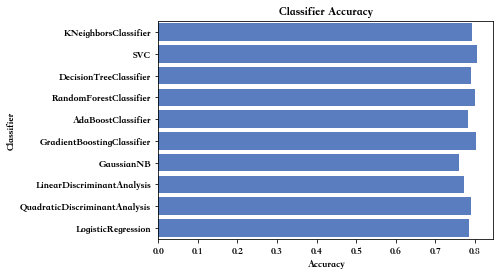

In [41]:
acc_dict = {}

for train_index, test_index in sss.split(X, y):
	X_train, X_test = X[train_index], X[test_index]
	y_train, y_test = y[train_index], y[test_index]
	
	for clf in classifiers:
		name = clf.__class__.__name__
		clf.fit(X_train, y_train)
		train_predictions = clf.predict(X_test)
		acc = accuracy_score(y_test, train_predictions)
		if name in acc_dict:
			acc_dict[name] += acc
		else:
			acc_dict[name] = acc

for clf in acc_dict:
	acc_dict[clf] = acc_dict[clf] / 10.0
	log_entry = pd.DataFrame([[clf, acc_dict[clf]]], columns=log_cols)
	log = log.append(log_entry)

plt.xlabel('Accuracy')
plt.title('Classifier Accuracy')

sns.set_color_codes("muted")
sns.barplot(x='Accuracy', y='Classifier', data=log, color="b");

In [43]:
candidate_classifier = SVC(gamma = 'auto')
candidate_classifier.fit(train[0::, 1::], train[0::, 0])
result = candidate_classifier.predict(test)